# Neural Creative Transfer

We implement a modification of Gatys, Ecker and Bethge's [neural style transfer algorithm](http://arxiv.org/abs/1508.06576).

The algorith uses a VGG-19 network to separate and recombine content of an creative and style of a website, and therefore provides a system for creating native creative for advertising. 

In [19]:
import os
import sys

import urllib
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf 

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image as pilImage

%matplotlib inline

In [27]:
###############################################################################
# Constants
###############################################################################
# Weight to put more emphasis on the content loss.
ALPHA = 5
# Weight to put more emphasis on the style loss.
BETA = 1000
# Max iteration to run the optimizer
MAX_ITERATION = 1000
#Number of iterations between optimizer print statements
PRINT_ITERATION = 50
#Default style layers from the VGG to be included in the 
STYLE_LAYERS = [
    ('conv1_1', 1.0),
    ('conv2_1', 2.0),
    ('conv3_1', 3.0),
    ('conv4_1', 4.0),
    ('conv5_1', 5.0),
]
#Default content layers from the VGG to be included
CONTENT_LAYERS = [
    ('conv4_2', 1.0),
]
# Mixing ratio between the content image and noise image that the network is initialized with
NOISE_RATIO = 0.8
# Input to the VGG model expects the mean to be subtracted from 
# the image. This is the one used during training VGG.
MEAN_IMAGE = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

# The repo folder
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
# Output folder for the images.
OUTPUT_DIR = 'output/'
# Input folders for the images.
INPUT_DIR = 'resources/images/'
# Model folder
MODEL_DIR = 'resources/models/'


In [36]:
def setup_network_from_file(model_name, image):
    """
    We start with the pre-trained VGG model from the paper "Very Deep Convolutional
    Networks for Large-Scale Visual Recognition". We  strip out all the conv, relu
    and pool layers from the VGG-19 network and replace the maxpool layers with 
    average pool layers as suggested by the authors in the "A Neural Algorithm of 
    Artistic Style" paper. Here is the configuration for our modified VGG network 
    (layer : filter height, filter width, input channels, output channels):
        conv1_1  :  3  3  3    64
        conv1_2  :  3  3  64   64 
        avgpool  :
        conv2_1  :  3  3  64   128  
        conv2_2  :  3  3  128  128 
        avgpool  :
        conv3_1  :  3  3  128  256 
        conv3_2  :  3  3  256  256
        conv3_3  :  3  3  256  256
        conv3_4  :  3  3  256  256
        avgpool  :
        conv4_1  :  3  3  256  512  
        conv4_2  :  3  3  512  512
        conv4_3  :  3  3  512  512
        conv4_4  :  3  3  512  512
        avgpool  :
        conv5_1  :  3  3  512  512 
        conv5_2  :  3  3  512  512 
        conv5_3  :  3  3  512  512 
        conv5_4  :  3  3  512  512 
        avgpool  :    
    """
    
    _, image_height, image_width, color_channels = image.shape
    
    full_path = os.path.join(BASE_DIR, MODEL_DIR, model_name)
    # Strip out the layers from the VGG-19 model 
    vgg = scipy.io.loadmat(full_path)['layers'] 
    
    def _weights(layer):
        """
        Extract the weights at a given layer.
        """
        W = vgg[0][layer][0][0][2][0][0]
        return tf.constant(W)
    
    def _bias(layer):
        """
        Extract the bias at a given layer.
        """
        b = vgg[0][layer][0][0][2][0][1]
        return tf.constant(np.reshape(b, (b.size)))

    def _conv2d(input_layer, layer):
        """
        Construct the conv2d layer.
        """
        W = _weights(layer)
        b = _bias(layer)
        return tf.nn.conv2d(input_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b
    
    def _relu(input_layer):
        """
        Construct the relu layer.
        """
        return tf.nn.relu(input_layer)

    def _avg_pool(input_layer):
        """
        Return the average pooling layer.
        """
        return tf.nn.avg_pool(input_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Set up the modifiled VGG network.  
    network = {}
    network['input']    = tf.Variable(np.zeros((1, image_height, image_width, color_channels)), dtype = np.float32)
    
    network['conv1_1']  = _conv2d(network['input'], 0)
    network['relu1_1']  = _relu(network['conv1_1'])
    network['conv1_2']  = _conv2d(network['relu1_1'], 2) 
    network['relu1_2']  = _relu(network['conv1_2'])    
    network['avgpool1'] = _avg_pool(network['relu1_2'])
    
    network['conv2_1']  = _conv2d(network['avgpool1'], 5)
    network['relu2_1']  = _relu(network['conv2_1'])
    network['conv2_2']  = _conv2d(network['relu2_1'], 7)
    network['relu2_2']  = _relu(network['conv2_2'])
    network['avgpool2'] = _avg_pool(network['relu2_2'])
    
    network['conv3_1']  = _conv2d(network['avgpool2'], 10)
    network['relu3_1']  = _relu(network['conv3_1'])
    network['conv3_2']  = _conv2d(network['relu3_1'], 12)
    network['relu3_2']  = _relu(network['conv3_2'])
    network['conv3_3']  = _conv2d(network['relu3_2'], 14)
    network['relu3_3']  = _relu(network['conv3_3'])
    network['conv3_4']  = _conv2d(network['relu3_3'], 16)
    network['relu3_4']  = _relu(network['conv3_4'])
    network['avgpool3'] = _avg_pool(network['relu3_4'])
    
    network['conv4_1']  = _conv2d(network['avgpool3'], 19)
    network['relu4_1']  = _relu(network['conv4_1'])
    network['conv4_2']  = _conv2d(network['relu4_1'], 21)
    network['relu4_2']  = _relu(network['conv4_2'])
    network['conv4_3']  = _conv2d(network['relu4_2'], 23)
    network['relu4_3']  = _relu(network['conv4_3'])
    network['conv4_4']  = _conv2d(network['relu4_3'], 25)
    network['relu4_4']  = _relu(network['conv4_4'])
    network['avgpool4'] = _avg_pool(network['relu4_4'])
    
    network['conv5_1']  = _conv2d(network['avgpool4'], 28)
    network['relu5_1']  = _relu(network['conv5_1'])
    network['conv5_2']  = _conv2d(network['relu5_1'], 30)
    network['relu5_2']  = _relu(network['conv5_2'])
    network['conv5_3']  = _conv2d(network['relu5_2'], 32)
    network['relu5_3']  = _relu(network['conv5_3'])
    network['conv5_4']  = _conv2d(network['relu5_3'], 34)
    network['relu5_4']  = _relu(network['conv5_4'])
    network['avgpool5'] = _avg_pool(network['relu5_4'])
    
    return network

In [2]:
def content_loss_func(sess, network, image, content_layers = []):
    """
    Content loss function.
    """
    def _content_loss(p, x):
        _, height, width, depth = p.get_shape()
        # N is the number of the output channels.
        N = depth.value
        # M is the size of the feature map.
        M = height.value * width.value
        # I use a similar normalization constant to the one used in
        # style loss instead of the one in the paper, which is 0.5
        C = 1. / (2 * N * M)
        return C * tf.reduce_sum(tf.pow(x - p, 2))
    
    sess.run(network['input'].assign(image))
    content_loss = sum([_content_loss(sess.run(network[layer]), network[layer]) * weight
                        for layer, weight in content_loss])
        
    return content_loss / len(content_layers)

def style_loss_func(sess, network, image, style_layers = []):
    """
    Style loss function as defined in the paper.
    """
    def _gram_matrix(x, N, M):
        """
        The gram matrix.
        """
        F = tf.reshape(x, (M, N))
        return tf.matmul(tf.transpose(F), F)

    def _style_loss(a, x):
        """
        The style loss calculation.
        """
        _, height, width, depth = a.get_shape()
        # N is the number of the output channels.
        N = depth.value
        # M is the size of the feature map.
        M = height.value * width.value
        # A is the style representation of the original image.
        A = _gram_matrix(a, N, M)
        # G is the style representation of the generated image.
        G = _gram_matrix(x, N, M)
        # normalization factor
        C = 1. / (4 * N**2 * M**2)

        return C * tf.reduce_sum(tf.pow(G - A, 2))

    sess.run(network['input'].assign(image))
    style_loss = sum([_style_loss(sess.run(network[layer]), network[layer]) * weight
                      for layer, weight in style_layers])
    
    return style_loss

In [8]:
def style_transfer(content_img, style_img, init_img, **kwargs):
  with tf.Session() as sess:
    
    assert content_img.shape == style_imgs.shape
    
    # setup the modifield VGG network
    network = setup_network_from_file(content_img)
    
    # loss weights and configurations
    alpha = kwargs.get('alpha', ALPHA)
    beta  = kwargs.get('beta', BETA)

    # content loss
    L_content = content_loss_func(sess, network, content_img,
                                  content_layers = kwargs.get('content_layers', CONTENT_LAYERS))
    
    # style loss
    L_style = style_loss_func(sess, network, style_img,
                              style_layers =kwargs.get('style_layers', STYLE_LAYERS))
    
    # total loss
    L_total  = alpha * L_content + beta  * L_style
    
    # 'L-BFGS-B' requires much less tuning compared to 'Adam'
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(
        L_total, 
        method='L-BFGS-B',
        options={'maxiter': kwargs.get('maxiter', MAX_ITERATION),
                 'disp': kwargs.get('maxiter', PRINT_ITERATION)})
    
    # Optimizing the loss function
    sess.run(tf.global_variables_initializer())
    sess.run(init_op)
    sess.run(net['input'].assign(init_img))
    optimizer.minimize(sess)
    
    output_img = sess.run(net['input'])
    
    return output_img

In [13]:
def retrieve_image(url, image_name):
    """
        Retrieve the image from the url,  save it at the input 
        directory, and return its centralized pixel array 
    """
    path = os.path.join(BASE_DIR, INPUT_DIR, image_name)
    urllib.urlretrieve(url, path)
    return load_image(path)

def load_image(path):
    image = scipy.misc.imread(path)
    # Resize the image for VGG
    image = np.reshape(image, ((1,) + image.shape))
    # Subtract the mean (VGG) before returning 
    return image - MEAN_IMAGE

def save_image(path, image):
    # Add back the mean before saving.
    image = image + MEAN_IMAGE
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

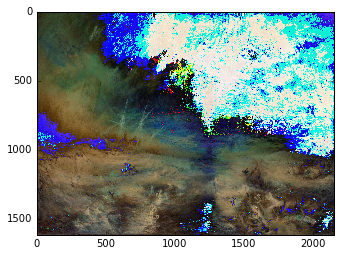

In [20]:
img = retrieve_image("https://upload.wikimedia.org/wikipedia/commons/2/26/Slave-ship.jpg","William_Turner_ship.jpg")
imshow(img[0])

In [25]:
def get_init_content_image(content_image, noise_ratio = NOISE_RATIO, seed = 0):
    np.random.seed(seed)
    noise_image = np.random.normal(size=content_image.shape,
                                   scale=np.std(content_image) * 0.1).astype(np.float32)
    return noise_image * noise_ratio + content_image * (1.-noise_ratio) 

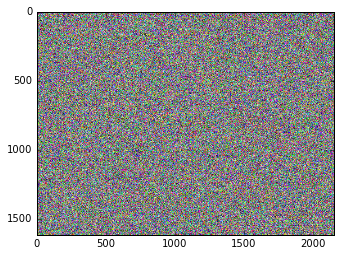

In [26]:
noise_img = get_init_content_image(img,)
imshow(noise_img[0])

In [37]:
model = setup_network_from_file("imagenet-vgg-verydeep-19.mat", img)
print(model)

{'conv1_1': <tf.Tensor 'add_18:0' shape=(1, 1616, 2152, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'add_19:0' shape=(1, 1616, 2152, 64) dtype=float32>, 'conv5_4': <tf.Tensor 'add_33:0' shape=(1, 101, 135, 512) dtype=float32>, 'conv5_1': <tf.Tensor 'add_30:0' shape=(1, 101, 135, 512) dtype=float32>, 'conv5_3': <tf.Tensor 'add_32:0' shape=(1, 101, 135, 512) dtype=float32>, 'conv5_2': <tf.Tensor 'add_31:0' shape=(1, 101, 135, 512) dtype=float32>, 'conv4_4': <tf.Tensor 'add_29:0' shape=(1, 202, 269, 512) dtype=float32>, 'conv4_1': <tf.Tensor 'add_26:0' shape=(1, 202, 269, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'add_27:0' shape=(1, 202, 269, 512) dtype=float32>, 'conv4_3': <tf.Tensor 'add_28:0' shape=(1, 202, 269, 512) dtype=float32>, 'conv3_4': <tf.Tensor 'add_25:0' shape=(1, 404, 538, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'add_24:0' shape=(1, 404, 538, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'add_23:0' shape=(1, 404, 538, 256) dtype=float32>, 'conv3_1': <tf.Tensor 'add_22:0' sh